In [1]:
import pandas as pd
import os
import sys
import re
import json
import concurrent.futures
from tqdm import tqdm
import random
import pickle
from sklearn.model_selection import train_test_split
import torch
import pickle 

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
text_num_mapping_start = 1
model_test_run = False #This reduces the data generated by selecting significantly lesser number of sessions to test the model
remove_consecutive_identical_clicks = False
#Todo implement identical consecutive clicks - only do that if the timedelta between clicks is quite less- otherwise it doesnt make sense.
sequence_augmentation = True
carsi_labels_only = True

PATH_TO_LOAD = '../data/04_Merged'
base_path = '../datasets/sequential/'
augmentation_folder = 'aug/' if sequence_augmentation else 'non_aug/'
if model_test_run:
    augmentation_folder = 'test/aug/' if sequence_augmentation else 'test/non_aug/'
parameter_path = f'{base_path}{augmentation_folder}parameters'
sequence_path = f'{base_path}{augmentation_folder}seq'

In [3]:
def load_df(vehicle):
    df = pd.read_csv(os.path.join(PATH_TO_LOAD, vehicle + "_merged.csv"), parse_dates=['datetime'], low_memory=False, index_col=0)
    df = df.dropna(subset=['Label'])
    df = df.sort_values(by=['session', 'datetime'])
    if carsi_labels_only:
        df['full_label'] = df['Label']
    else:
        mask = df['Label'] == 'navi/Start/Address'
        df.loc[mask, 'FunctionValue'] = 'a'
        df['full_label'] = df['Label'] + ' ' + df['FunctionValue']
    return df

full_df = pd.DataFrame()

vehicles = ['SEB880','SEB882','SEB883','SEB885','SEB888','SEB889']

def process_vehicle(vehicle):
    df_curr = load_df(vehicle)
    df_curr['vehicle'] = vehicle
    df_curr = df_curr.dropna(subset=['full_label'])
    return df_curr

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(tqdm(executor.map(process_vehicle, vehicles), total=len(vehicles)))

full_df = pd.concat(results, ignore_index=True)

100%|██████████| 6/6 [00:42<00:00,  7.15s/it]


In [4]:
if model_test_run:
    session = full_df.session.unique().tolist()
    random_seed = 42
    random.seed(random_seed)
    selected_elements = random.sample(session, 10)
    full_df = full_df[full_df['session'].isin(selected_elements)].sort_index()

mapping = {category: index + text_num_mapping_start for index, category in enumerate(full_df['full_label'].unique())}
full_df['full_label_num'] = full_df['full_label'].replace(mapping)

with open(os.path.join(parameter_path, 'label_mapping.pkl'), 'wb') as pickle_file:
        pickle.dump(mapping, pickle_file)

mapping_vehicle = {category: index + text_num_mapping_start for index, category in enumerate(full_df['vehicle'].unique())}
full_df['vehicle_num'] = full_df['vehicle'].replace(mapping_vehicle)
check = full_df.copy()

28


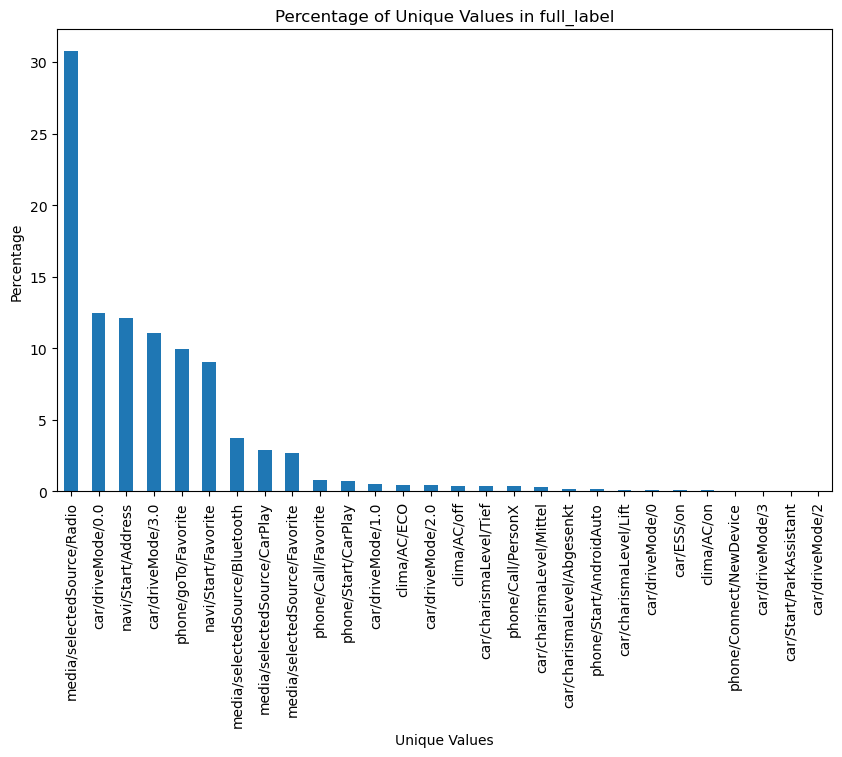

In [5]:
print(len(check['Label'].unique().tolist()))
import matplotlib.pyplot as plt

# Assuming your DataFrame is named full_df
value_counts = check['Label'].value_counts(normalize=True) * 100

# Plotting the bar chart
plt.figure(figsize=(10, 6))
value_counts.plot(kind='bar')
plt.title('Percentage of Unique Values in full_label')
plt.xlabel('Unique Values')
plt.ylabel('Percentage')
plt.show()


In [6]:

filt_df = full_df[['session','full_label_num','vehicle_num', 'datetime']].sort_values(by = ['session', 'datetime'])
filt_df = filt_df.drop_duplicates()

filt_df['interaction_time_delta'] = (filt_df.groupby('session')['datetime'].diff().dt.total_seconds()/60).round(1)
filt_df['interaction_time_delta'] = filt_df['interaction_time_delta'].fillna(0)
filt_df['interaction_time_delta']   = filt_df['interaction_time_delta'].astype(int)

def filter_rows(session_df):
    rows_to_delete = []
    prev_row = None

    for _, row in session_df.iterrows():
        if prev_row is not None and row['full_label_num'] == prev_row['full_label_num'] and row['interaction_time_delta'] < 0.5:
            rows_to_delete.append(prev_row.name)
        prev_row = row
    session_df = session_df.drop(index=rows_to_delete)
    return session_df

# Apply the function to each session
if remove_consecutive_identical_clicks:
    filt_df = filt_df.groupby('session').apply(filter_rows)
    filt_df = filt_df.droplevel('session').reset_index(drop=True)
    filt_df['interaction_time_delta'] = (filt_df.groupby('session')['datetime'].diff().dt.total_seconds()/60).round(1)
    filt_df['interaction_time_delta'] = filt_df['interaction_time_delta'].fillna(0)
    filt_df['interaction_time_delta']   = filt_df['interaction_time_delta'].astype(int)

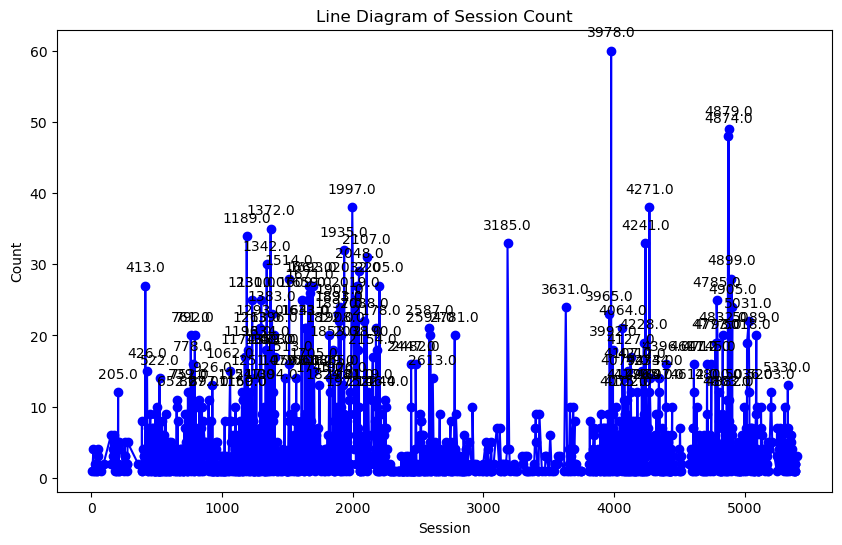

In [7]:
data = filt_df.session.value_counts().sort_index()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(data.index, data.values, marker='o', linestyle='-', color='b')

for session, count in data.items():
    if count > 10:
        plt.annotate(f'{session}', (session, count), textcoords="offset points", xytext=(0, 10), ha='center')


# Adding labels and title
plt.xlabel('Session')
plt.ylabel('Count')
plt.title('Line Diagram of Session Count')

# Display the plot
plt.show()

28


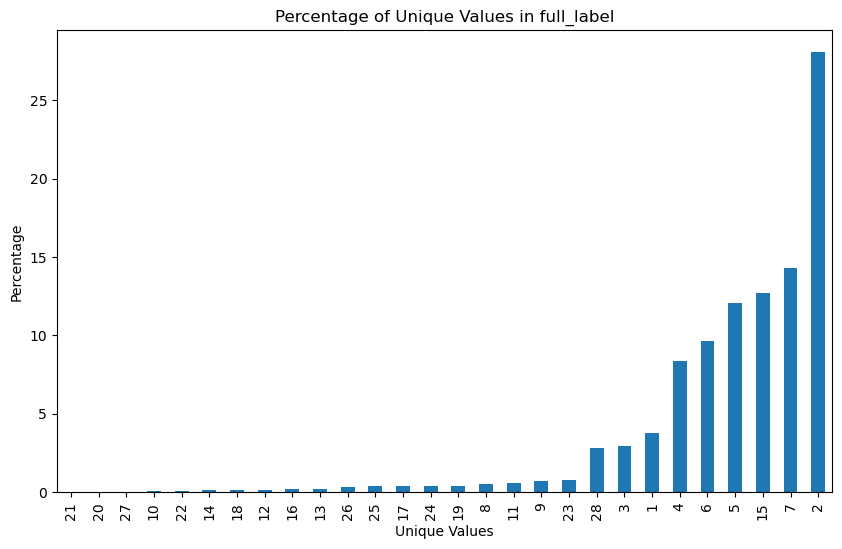

In [8]:
print(len(filt_df['full_label_num'].unique().tolist()))
import matplotlib.pyplot as plt

# Assuming your DataFrame is named full_df
value_counts = filt_df['full_label_num'].value_counts(normalize=True).sort_values() * 100

# Plotting the bar chart
plt.figure(figsize=(10, 6))
value_counts.plot(kind='bar')
plt.title('Percentage of Unique Values in full_label')
plt.xlabel('Unique Values')
plt.ylabel('Percentage')
plt.show()


In [9]:
# To do add those session with just one interactions. that one interaction can the target and input sequence can be no click along with the context
# find session with just one interactions
session_counts = filt_df['session'].value_counts()
session_with_one_interactions = session_counts[session_counts == 1].index.tolist()
one_interactions = filt_df[filt_df['session'].isin(session_with_one_interactions)]

In [10]:
relevanat_df = filt_df[~filt_df['session'].isin(session_with_one_interactions)]
len(relevanat_df.session.unique().tolist())
# this is used to generate the appropriate context file
relevanat_df[['session', 'datetime']].to_csv(os.path.join(parameter_path, 'sequence_context.csv'))

In [11]:
## Generating augmented data
def explode_both(row):
        sequences = row['sequence']
        time_deltas = row['time_delta']
        sessions = [row['session']] * len(sequences)
        return pd.DataFrame({'session': sessions, 'sequence': sequences, 'time_delta': time_deltas})

def sequence_generation(df, sequence_augmentation):
    sequence_dict = {
        'session': [],
        'sequence': [],
        'time_delta': []
    }
    if sequence_augmentation == True:
        for session in df['session'].unique().tolist():
            check_df = df[df['session']== session]

            sequence_list = []
            time_delta_list = []
            seq_length = len(check_df)
            sequence = check_df['full_label_num'].tolist()
            time_delta = check_df['interaction_time_delta'].tolist()
            # print(session)
            # print(seq_length)
            # print(sequence)
            # print(time_delta)
            while seq_length != 1:
                sequence_list.append(sequence)
                time_delta_list.append(time_delta)
                # print(sequence_list)
                # print(time_delta_list)
                time_delta = time_delta[:-1]
                sequence = sequence[:-1]
                seq_length = seq_length -1
            sequence_dict['session'].append(session)
            sequence_dict['sequence'].append(sequence_list)
            sequence_dict['time_delta'].append(time_delta_list)
        sequence_df = pd.DataFrame(sequence_dict)
        sequence_df = pd.concat(sequence_df.apply(explode_both, axis=1).tolist(), ignore_index=True)
    else:
        for session in df['session'].unique().tolist():
            check_df = df[df['session']== session]
            
            if len(check_df) == 1:
                 continue
            sequence_list = []
            time_delta_list = []
            seq_length = len(check_df)
            sequence = check_df['full_label_num'].tolist()
            time_delta = check_df['interaction_time_delta'].tolist()
            
            sequence_dict['session'].append(session)
            sequence_dict['sequence'].append(sequence)
            sequence_dict['time_delta'].append(time_delta)
        sequence_df = pd.DataFrame(sequence_dict)

    return sequence_df

clean_df = filt_df.drop(columns=['datetime', 'vehicle_num'])
df_exploded = sequence_generation(clean_df, sequence_augmentation)
df_exploded['time_delta_list'] = df_exploded['time_delta'].apply(lambda x: x[1:] if isinstance(x, list) and len(x) > 1 else x)
df_exploded['interaction_time_delta_train'] = df_exploded['time_delta_list'].apply(lambda x: ' '.join(map(str, x)) if isinstance(x, list) else x)
df_exploded['item_id_seq_train'] = df_exploded['sequence'].apply(lambda x: ' '.join(map(str, x[:-1])) if isinstance(x, list) and len(x) > 1 else None)
df_exploded['item_id_target'] = df_exploded['sequence'].apply(lambda x: x[-1] if isinstance(x, list) and len(x) > 0 else None)
df_exploded = df_exploded.dropna(subset=['item_id_target'])
df_exploded['item_id_target'] = df_exploded['item_id_target'].astype(int)
df_exploded = df_exploded.drop(columns=['sequence', 'time_delta', 'time_delta_list'])

In [12]:
if sequence_augmentation == True:
      total_sessions = df_exploded.session.unique().tolist()
      test_sessions, train_sessions = train_test_split(total_sessions, test_size=0.8, shuffle=True, random_state=42)
      train_df = df_exploded[df_exploded['session'].isin(train_sessions)].sort_index()
      test_df = df_exploded[df_exploded['session'].isin(test_sessions)].sort_index()
else:
      train_df, test_df = train_test_split(df_exploded, test_size=0.2, shuffle=True, random_state=42)
      train_df = train_df.sort_index()
      test_df = test_df.sort_index()
      train_sessions = train_df['session'].unique().tolist()
      test_sessions = test_df['session'].unique().tolist()

with open(os.path.join(parameter_path, 'train_sessions.pkl'), 'wb') as pickle_file:
        pickle.dump(train_sessions, pickle_file)

with open(os.path.join(parameter_path, 'test_sessions.pkl'), 'wb') as pickle_file:
        pickle.dump(test_sessions, pickle_file)

train_df = train_df.sort_values(by='session')
test_df = test_df.sort_values(by='session')

train_df = train_df.drop(['session'], axis=1)
test_df = test_df.drop(['session'], axis=1)

test_df['window_id'] = range(len(test_df))
test_df['window_id'] = test_df['window_id'].astype(int)

train_df['window_id'] = range(len(train_df))
train_df['window_id'] = train_df['window_id'].astype(int)

train_df = train_df[['window_id', 'item_id_seq_train', 'item_id_target', 'interaction_time_delta_train']]
test_df = test_df[['window_id', 'item_id_seq_train', 'item_id_target', 'interaction_time_delta_train']]

test_df.to_csv(os.path.join(sequence_path, 'test.tsv'), sep='\t', index=False)
train_df.to_csv(os.path.join(sequence_path, 'train.tsv'), sep='\t', index=False)

In [13]:
train_df

,window_id,item_id_seq_train,item_id_target,interaction_time_delta_train
0,0,2 1 2,2,10 21 19
1,1,2 1,2,10 21
2,2,2,1,10
4,3,4,5,0
5,4,4,5,0
...,...,...,...,...
5448,4421,2,4,23
5446,4422,2 4 5,2,23 0 12
5449,4423,5,6,0
5450,4424,7,15,8


In [14]:
file_path = os.path.join(sequence_path, 'train.tsv')
train_data = pd.read_csv(file_path, sep='\t')

def compute_class_weights(data):
    labels = torch.tensor(data.item_id_target)
    class_count = torch.bincount(labels)
    total_samples = len(labels)
    epsilon = 1e-5
    class_weights = 1.0 / ((class_count.float()) / total_samples)
    small_value = 1e-20
    class_weights[torch.isinf(class_weights)] = small_value
    # class_weights = torch.where(torch.isinf(class_weights), torch.tensor(0.0), class_weights)
    sum_weights = torch.sum(class_weights)
    class_weights = class_weights / sum_weights
    return class_weights

class_weights = compute_class_weights(df_exploded)
# class_weights = class_weights[1:]
with open(os.path.join(parameter_path, 'param.pkl'), 'wb') as f:
        pickle.dump(class_weights, f)

print(class_weights.size(), len(df_exploded.item_id_target.unique().tolist()))

torch.Size([29]) 27


In [15]:
class_weights

tensor([4.7154e-25, 1.3977e-03, 1.8910e-04, 1.5493e-03, 5.5426e-04, 3.3618e-04,
        5.4029e-04, 2.6459e-04, 1.3536e-02, 6.2726e-03, 4.7154e-25, 7.7933e-03,
        2.8575e-02, 1.8370e-02, 2.8575e-02, 4.1480e-04, 2.5718e-02, 1.1690e-02,
        3.2147e-02, 1.0287e-02, 1.2859e-01, 2.5718e-01, 2.5718e-01, 4.7626e-03,
        9.8915e-03, 1.0716e-02, 1.2859e-02, 1.2859e-01, 2.0250e-03])

In [16]:
df_exploded

,session,interaction_time_delta_train,item_id_seq_train,item_id_target
0,16.0,10 21 19,2 1 2,2
1,16.0,10 21,2 1,2
2,16.0,10,2,1
3,25.0,0,3,2
4,33.0,0,4,5
...,...,...,...,...
5449,5387.0,0,5,6
5450,5388.0,8,7,15
5451,5389.0,75,2,6
5452,5399.0,27 11,7 11,7


In [17]:
sorted(df_exploded.item_id_target.unique().tolist())

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28]

23


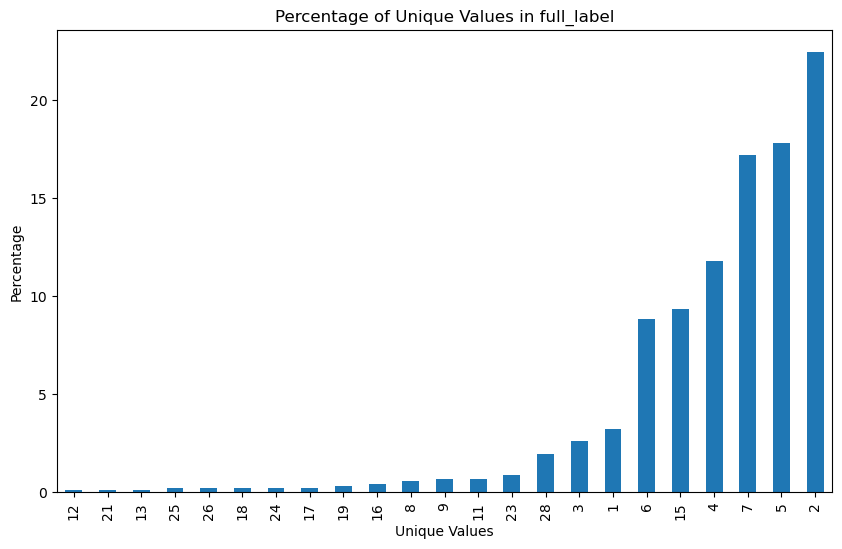

In [18]:
print(len(test_df['item_id_target'].unique().tolist()))
import matplotlib.pyplot as plt

# Assuming your DataFrame is named full_df
value_counts = test_df['item_id_target'].value_counts(normalize=True).sort_values() * 100

# Plotting the bar chart
plt.figure(figsize=(10, 6))
value_counts.plot(kind='bar')
plt.title('Percentage of Unique Values in full_label')
plt.xlabel('Unique Values')
plt.ylabel('Percentage')
plt.show()
